## Управление ориентацией самолетов с неподвижным крылом с использованием Q-Learning 

Постановка задачи: В начале эпизода самолет отклоняется от горизонтально траектории и от агента требуется вернуть самолет в изначальное положение, используя базовые элементы управления: тангаж и крен, эпизд заканчивается, когда угловые координаты самолета (Roll, Ritch) находятся в окрестности нуля.

Количество состояний описывается следующим алгоритмом:

Разделим полуинтервал от [-180;180) на 13 частей: [-180; -75), [-75;-35), [-35, -15), [-15, -5), [-5, -2), [-2, -1), [-1, 1), [1, 2), [2, 5), [5, 15), [15, 35), [35, 75), [75, 180) и будем говорить, если угол попал в интервал i то он будет иметь бин i, так как угла два $\to$ получается два бина соответственно по двум бинам и определяется состояние системы. через формулу:

$$s_i = 13\phi_i + \theta_i$$ 

Действием в данной задаче является отклонения руля тангажа и крена на некоторую величину, которая меняется от -1 до 1 для каждого элемента управления. Для выбора действия предоставляется следующее разбиение(предсталенно разбиение полуинтервала от [-180, 0) так как при положительном угла знак действия будет менятся):

In [5]:
table = [
    ["[-180, -50)", 0.75],
    ["[-50, -25)", 0.66],
    ["[-25, -15)", 0.50],
    ["[-15, -5)", 0.33],
    ["[-5, -2)", 0.1],
    ["[-2, -1)", 0.05],
    ["[-1, 0)", 0.025]
]
import pandas as pd
pd.DataFrame(table, columns=["Полуинтервал", "Значение отнлонения"])

,Полуинтервал,Значение отнлонения
0,"[-180, -50)",0.750
1,"[-50, -25)",0.660
2,"[-25, -15)",0.500
3,"[-15, -5)",0.330
4,"[-5, -2)",0.100
5,"[-2, -1)",0.050
6,"[-1, 0)",0.025


Как можно видеть у агента есть три возможность отклонения руля. Так что в итоге набор действий будет таким:
* дополнительно отклонить руль тангажа/крена на величену положительного отклонения.
* дополнительно отклонить руль тангажа/крена на величену отрицательного отклонения.
* отклонить и руль тангажа и руль крена на величены (-б,-м),(-б,м),(б,-м),(-б,-м) ... и так далее (каждое б, м либо плюс, либо минус, где б - большее значение, м - меньшее) 
таким образом 20 варианта

Награда: Награда определяется после каждого действия, считываев два угла, определяющих положение самолета, и вычисляем награду.  

$$r=(2 - (\frac{|\phi|}{180}+\frac{|\theta|}{180}))^2$$ 

Кроме того дополнительно уменьшаем награду, если самолет оказался вне некоторого угла, делается для того, что бы раница между плохим и очень плохим или хорошим и очень хорошим была очевиднее.

$$ r = r * 0.1 ~~if |\theta|, |\phi| > 40 \newline r = r * 0.25 ~~if |\theta|, |\phi| \in [20,40] \newline r = r * 0.5  ~~if |\theta|, |\phi| \in [10,20] \newline r = r * 0.75~~  if |\theta|, |\phi| \in [5,10] \newline r = r * 0.9  ~~if |\theta|, |\phi| \in [1,5]  $$


В данной задаче будем использовать Q-learning. Используя функции вознограждения он обучается и в конце представляетс наилучшие действия согласно модели.
 
По сути, Q-learning позволяет агенту использовать вознаграждения среды, чтобы со временем научиться наилучшим действиям в данном состоянии.

Для нашей задачи вознаграждения дается настолько больше, насколько близко агент сумеет привести самолет к нулевым Roll и Pitch

Значения запомненного вознаграждения, будем хранить в Q-таблице - словарем состояние+действие = значение, тем самым происходит обучение.

Q-значения инициализируются произвольным значением, и по мере того, как агент подвергается воздействию окружающей среды и получает различные вознаграждения за выполнение различных действий, Q-значения обновляются с использованием уравнения:

$$ Q(s, a) \leftarrow (1 - \alpha)Q(s, a) + \alpha(r + \gamma \max\limits_{a} Q(s_n, n_a) $$

Где:

- $\alpha$ - это скорость обучения ($0 < \alpha \leq 1$) - Так же, как и в условиях контролируемого обучения, это степень, с которой наши значения Q обновляются на каждой итерации.

- $\gamma$ - коэффициент скидки ($ 0 \leq \gamma \leq 1$) - определяет, затухание вознаграждения, чем больше итераций, тем меньше награда за верное решение.


В нашей задаче $\gamma$ = 1 c уменьшением в $\delta$ = 0.991 раза.
Так же фигурирует фактор случайности принятия решений $\epsilon$ = 0.5 - с его помощью агент принимет либо лучшее решение, либо случайное для вариативности процесса обучения.

In [6]:
import jsbsim
import numpy as np
from math import pi
fdm = jsbsim.FGFDMExec(None)
fdm.print_property_catalog()

In [7]:

# управляет действиями
class Actions:
    def __init__(self) -> None:
        self.table = {"sustation" : [i for i in range(169)], "position":[]}
        for i in range(13):
            for j in range(13):
                self.table["position"].append((i,j))
        # массивы с помощью которых определяется действия значение по двум полученым углам
        self.avalible_segments = [-180, -75, -35, -15, -5, -2,-1, 1, 2, 5, 15, 35, 75, 180]
        self.avalible_segments2 = [-1, -2, -5, -10, -15, -25, -50, -180]
        self.actions = [0.025, 0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75]
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.fdm["fcs/aileron-cmd-norm"] = 0
        self.fdm["fcs/elevator-cmd-norm"] = 0
        self.good_steps_counter = 0

    def Reset(self):
        self.fdm = jsbsim.FGFDMExec(None)
        self.fdm.disable_output()
        self.fdm["velocities/u-fps"] = 1000
        self.fdm.load_script("scripts/c172_cruise_8K.xml", False)
        self.fdm["fcs/aileron-cmd-norm"] = 0
        self.fdm["fcs/elevator-cmd-norm"] = 0
        self.fdm["ic/theta-deg"] = (np.random.random() * (2) - 1) * 15
        self.fdm["ic/phi-deg"] = (np.random.random() * (2) - 1) * 15
        self.fdm.run_ic()
        return self.Get_state()

    def change_roll(self, angle:float):
        self.fdm["fcs/aileron-cmd-norm"] += angle
        
    def change_pitch(self, angle:float):
        self.fdm["fcs/elevator-cmd-norm"] += angle

    def Get_roll(self):
        return self.fdm["attitude/roll-rad"] * 180*2/pi
    
    def Get_pitch(self):
        return self.fdm["attitude/pitch-rad"] * 180*2/pi

    def _get_bin(self, angle:float) -> int:
        for i in range(len(self.avalible_segments) - 1):
            if self.avalible_segments[i] <= angle < self.avalible_segments[i+1]:
                return i
        return 12
    def Get_state(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        return self.table["sustation"][(self._get_bin(roll) * 13 + self._get_bin(pitch))]

    def Get_actions(self) -> list:
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        sign = (lambda a: 1 if a > 0 else -1)
        roll_actions = (0, 0)
        pitch_actions = (0, 0)
        for i in range(len(self.avalible_segments2)):
            if abs(roll) < abs(self.avalible_segments2[i]):
                try:
                    roll_actions = np.array([self.actions[i] *  sign(roll), self.actions[i+1] *sign(roll)])
                    roll_actions = np.append(roll_actions, -1*roll_actions)
                except:
                    roll_actions = np.array([self.actions[i] *  sign(roll), self.actions[i-1] * -sign(roll)])
                    roll_actions = np.append(roll_actions, -1*roll_actions)
                break

        for i in range(len(self.avalible_segments2)):
            if abs(pitch) < abs(self.avalible_segments2[i]):
                try:
                    pitch_actions = np.array([self.actions[i] *  sign(pitch), self.actions[i+1] *sign(pitch)])
                    pitch_actions = np.append(pitch_actions, -1*pitch_actions)
                except:
                    pitch_actions = np.array([self.actions[i] *  sign(pitch), self.actions[i-1] *sign(pitch)])
                    pitch_actions = np.append(pitch_actions, -1*pitch_actions)
                break

        return [("roll", i) for i in roll_actions] + \
               [("pitch", i) for i in pitch_actions] +\
               [("double", i, j) for i in pitch_actions for j in roll_actions] 
            #    [("double", i, j) for i in pitch_actions for j in roll_actions] 
               



    def reward(self):
        roll = self.Get_roll()
        pitch = self.Get_pitch()
        r = (2 - ((abs(roll)/180 + abs(pitch)/180)/2)) ** 2
        if abs(roll) > 40 or abs(pitch) > 40:
            return r * 0.1
        elif abs(roll) > 20 or abs(pitch) > 20:
            return r * 0.25
        elif abs(roll) > 10 or abs(pitch) > 10:
            return r * 0.5
        elif abs(roll) > 5 or abs(pitch) > 5:
            return r * 0.75
        elif abs(roll) > 1 or abs(pitch) > 1:
            return r * 0.9
        else:
            return 1
    
    def Step(self, tup):
        if tup[0] == "double":
            self.change_roll(tup[1])
            self.change_pitch(tup[2])
        elif tup[0] == "roll":
            self.change_roll(tup[1])
        else:
            self.change_pitch(tup[1])
        reward = self.reward()
        done = False
        if self.Get_roll() > 1 or self.Get_roll() < -1 or self.Get_pitch() > 1 or self.Get_pitch() < -1:
            self.good_steps_counter = 0
        else:
            self.good_steps_counter += 1

        if self.good_steps_counter == 10000:
            done = True
            self.good_steps_counter = 0
        # done = (lambda Roll, Pitch: True if -1 < Roll and Roll > 1\
        #     and -1 < Pitch and Pitch > 1 else False) (self.Get_roll(), self.Get_pitch())
        return self.Get_state(), reward, done
    
import math

r = np.array([0,1])
d = (2,3)

print(np.append(d, -r))
from collections import defaultdict
import numpy as np
import time

class QLearningAgent:
   
    def __init__(self, alpha, epsilon, gamma, actions:Actions) -> None:
        self._q_values = defaultdict(lambda: defaultdict(lambda : 0))
        self.alpha = alpha # lr = 0.01
        self.gamma = gamma # gamma = 0.95
        self.epsilon = epsilon #eps = 0.5
        self.actions = actions

    def Set_q_value(self, state, action, value):
        self._q_values[state][action] = value

    def Get_q_value(self, state, action):
        return self._q_values[state][action]

    def Get_value(self):
        actions = self.actions.Get_actions()
        state = self.actions.Get_state()
        value = max([self.Get_q_value(state, action) for action in actions])
        return value

    def Policy(self):
        state = self.actions.Get_state()
        actions = self.actions.Get_actions()
        best_action = actions[0]
        for action in actions:
            if self.Get_q_value(state, action) > self.Get_q_value(state, best_action):
                best_action = action
        return best_action
            

    def Get_action(self):
        actions = self.actions.Get_actions()
        if np.random.random() < self.epsilon:
            action = actions[np.random.choice([i for i in range(len(actions))], 1)[0]]
        else:
            action = self.Policy()
        return action
    def Play(self):
        return self.Policy()
    
    def Update(self, state, action, reward):
        addition = self.alpha*(reward + self.gamma *(self.Get_value()-self.Get_q_value(state, action)))
        reference_value = self.Get_q_value(state, action) + addition
        self.Set_q_value(state, action, reference_value)

from collections import deque
from tqdm import tqdm

pitch_0 = []
roll_0 = []


[ 2  3  0 -1]


In [9]:


def interact(acts:Actions, agent:QLearningAgent, num_episodes=10000):
    average_reward_per_100_episodes = []
    best_average_reward_per_100_episodes = []
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    rewards = deque(maxlen=50000)

    for episode in tqdm(range(num_episodes)):
        state = acts.Reset()
        
        counter = 0
        curr_reward = 0
        agent.epsilon = 1
        while acts.fdm.run():
            counter += 1    
            if episode == 0:
                pitch_0.append(acts.Get_pitch())
                roll_0.append(acts.Get_roll())
            action = agent.Play()
            next_state, reward, done = acts.Step(action)
            agent.Update(next_state, action, reward)
            curr_reward += reward * agent.gamma
            agent.gamma *= 0.992
            state = next_state
            if done:
                rewards.append(curr_reward)
                break
          
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards)
            avg_rewards.append(avg_reward)
            print('average reward {}'.format(avg_reward))
            average_reward_per_100_episodes.append(avg_reward)
            best_average_reward_per_100_episodes.append(best_avg_reward)
    return avg_rewards, best_avg_reward

acts = Actions()
qlearn = QLearningAgent(0.01, 0.5, 1, acts)
avg_rewards, best_avg_reward = interact(acts, qlearn)

  0%|          | 0/10000 [00:00<?, ?it/s]
In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.
  0%|          | 1/10000 [00:01<4:22:53,  1.58s/it]

average reward 44.84740696603109



In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.
  0%|          | 2/10000 [00:04<6:14:09,  2.25s/it]
In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.
  0%|          | 3/10000 [00:05<5:28:32,  1.97s/it]
In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys 

In [ ]:
import time

acts.Reset()
pitch = []
roll = []
counter = 0
while acts.fdm.run():
    counter += 1
    roll.append(acts.Get_roll())
    pitch.append(acts.Get_pitch())
    action = qlearn.Play()
    next_state, reward, done = acts.Step(action)
    qlearn.Update(next_state, action, reward)
    state = next_state
    if done:
        break
    state = next_state



In file /home/anton/anaconda3/lib/python3.9/site-packages/jsbsim/systems/GNCUtilities.xml: line 68
      Property navigation/actual-heading-rad is already defined.
This vehicle has 6 bogeys, but the current 
version of FlightGear's FGNetFDM only supports 3 bogeys.
Only the first 3 bogeys will be used.


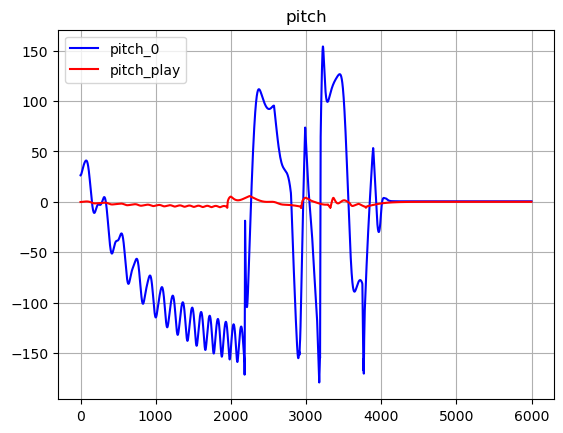

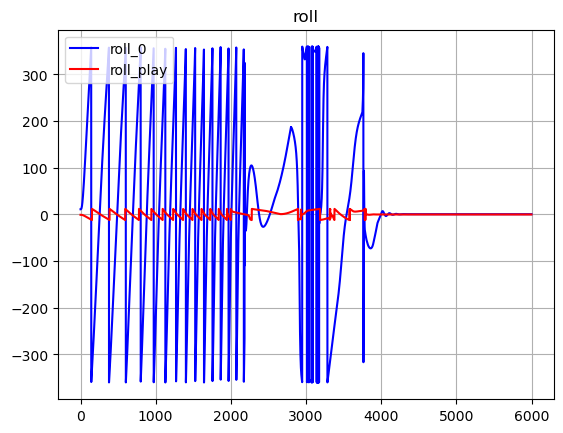

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(len(pitch_0)), pitch_0, c='b', label="pitch_0")
plt.plot(np.arange(len(pitch)), pitch, c='r', label="pitch_play")
plt.title("pitch")
plt.legend(loc='upper left')
plt.grid()
plt.show()

plt.figure(2)
plt.plot(np.arange(len(roll_0)), roll_0, c='b', label="roll_0")
plt.plot(np.arange(len(roll)), roll, c='r', label="roll_play")
plt.legend(loc='upper left')
plt.title("roll")
plt.grid()
plt.show()